# load

> Module for loading training and target files

In [ ]:
#| default_exp load

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

import numpy as np
import pkg_resources

In [ ]:
#| hide

import matplotlib.pylab as plt

In [ ]:
#| export

DATA_DIR = "data/"
LIBRARY_ZK_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "z_k.txt").name
LIBRARY_BK_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "Boost.npy").name
LIBRARY_PARAM_FILE = pkg_resources.resource_stream("CubicGalileonEmu", DATA_DIR + "cosmo_newdesign.txt").name
PARAM_NAME = [r"$\Omega_m*h^2$", r"$n_s$", r"$\sigma_8$", r"$E_{ds}$", r"$f_\phi$"]

In [ ]:
#| export

def load_boost_training(Bk_fileIn:str=LIBRARY_BK_FILE, # Input file for Boost
                        Zk_fileIn:str=LIBRARY_ZK_FILE, # Input file for redshift and wavenumbers
                        ) -> tuple: # Boost, wavenumbers, redshifts 
    Bk_all = np.load(Bk_fileIn)
    zk_all = np.loadtxt(Zk_fileIn)
    
    z_all = zk_all[:, 0][np.isfinite(zk_all[:, 0])]
    k_all = zk_all[:, 1]
    
    return Bk_all, k_all, z_all

In [ ]:
#| export

def load_params(p_fileIn:str=LIBRARY_PARAM_FILE, # Input file for parameters
               ) -> np.array: # Parameters
    p_all = np.loadtxt(p_fileIn)
    return p_all

In [ ]:
#| hide

Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

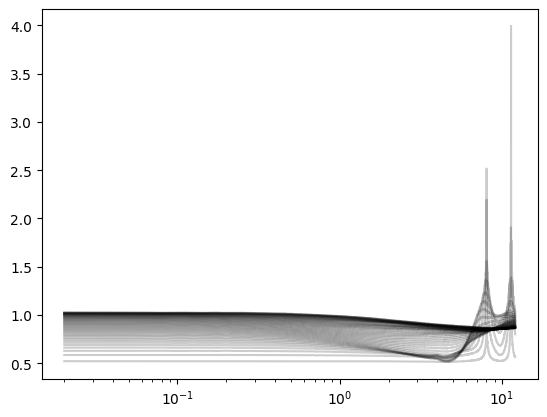

In [ ]:
#| hide

sim_index = 0

plt.figure(32)
for z_index in range(51):
    plt.plot(k_all, Bk_all[sim_index, z_index, :], 'k', alpha=0.2)
   
plt.xscale('log')
plt.show()

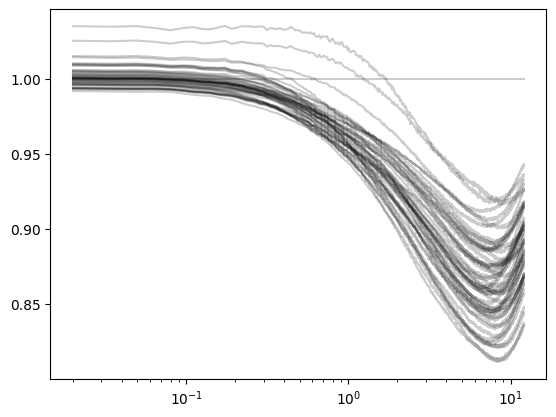

In [ ]:
#| hide

z_index = 12

plt.figure(32)
for sim_index in range(50):
    plt.plot(k_all, Bk_all[sim_index, z_index, :], 'k', alpha=0.2)
   
plt.xscale('log')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

/home/nramachandra/anaconda3/envs/qom_torch_tf/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/home/nramachandra/Projects/MG_emu/Codes/CubicGalileonEmu/nbs/index.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
